In [84]:
import subprocess 
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns
import itertools
import random
import math

## Generación de prueba

In [85]:
input_path = "../datos_entrada/ej2/"

In [86]:
def combinacionValida(n,ejes):
    for i in range(n,1,-1):
        if len([(x,y) for x,y in ejes if y == i or x == i]) == 0:
            return False
    return True
        

In [87]:
repeticiones=10
tamanios=range(2,11)
files = []
for n in tamanios:
    ejes_posibles = list(itertools.combinations(range(1,n+1),2))
    
    m = random.randint(1,len(ejes_posibles))
    
    random.shuffle(ejes_posibles)
    while not combinacionValida(n,ejes_posibles[0:m]):
        m = m + 1
    ejes = ejes_posibles[0:m]
    
    file = {
        "n": n,
        "m": m,
        "name": f"exp_random_{n}nodos_{m}ejes.txt",
        "absPath": os.path.abspath(f"{input_path}/exp_random_{n}nodos_{m}ejes.txt")
    }
    
    f = open(file["absPath"], "w")
    f.write(f"{n} {m}\n")
    for i in range(0,n):
        costo = random.randint(1,100)
        f.write(f"{costo}\n")
    for (src,dest) in ejes:
        distancia = random.randint(1,100)
        f.write(f"{src} {dest} {distancia}\n")
    f.close()
    
    files.append(file)

In [ ]:
def run(file,metodo):
    
    completado = subprocess.run(["../../Resolucion/bin/ej2",file["absPath"],str(metodo)], stdout=subprocess.PIPE, universal_newlines=True)
    if completado.returncode != 0:
        return "ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={0} metodo={1}".format(k,metodo)
    else:
        return completado.stdout

resultFile = f"{input_path}/results.txt"
tiempos = "./ej2_tiempos.csv"
f = open(resultFile,"a+")
for file in files:
    for i in range(1,repeticiones):
        if(file["n"] < 7):
            f.write(run(file,0)) #Dijkstra Arreglo
        f.write(run(file,1)) #Dijkstra Cola
        f.write(run(file,2)) #BellmanFord
        f.write(run(file,3)) #FloydWarshall    
    
f.close()

In [70]:
csv = pandas.read_csv(tiempos)

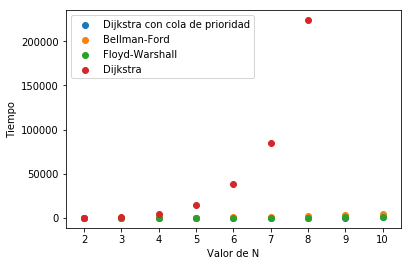

In [71]:
plt.clf()
for method in csv["Metodo"].unique():
    csvOnlyNames = csv.dropna(subset=['Filename'])
    methodResults = csvOnlyNames[csvOnlyNames["Metodo"]==method]
    resultsByN = [np.median(methodResults[methodResults["n"] == n]["Tiempo"]) for n in tamanios]
    plt.scatter(tamanios,resultsByN,label=method)


plt.legend();
plt.xlabel("Valor de N")
plt.ylabel("Tiempo");


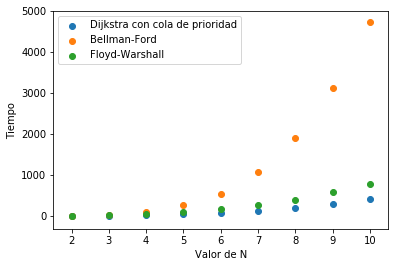

In [72]:
plt.clf()
for method in csv["Metodo"].unique():
    if method != "Dijkstra":
        csvOnlyNames = csv.dropna(subset=['Filename'])
        methodResults = csvOnlyNames[csvOnlyNames["Metodo"]==method]
        resultsByN = [np.median(methodResults[methodResults["n"] == n]["Tiempo"]) for n in tamanios]
        plt.scatter(tamanios,resultsByN,label=method)

plt.legend();
plt.xlabel("Valor de N")
plt.ylabel("Tiempo");

### Corelación entre tiempo de ejecución y cota de algortimo para cada una de estructuras

In [83]:
csv["nodosEnH"] = csv["n"] * 60
csv["logNodosEnH"] = np.log(csv["nodosEnH"])

csv["cotaDijkstra-Arreglo"] = csv["n"] * csv["nodosEnH"]**3
csv["cotaDijkstra-Cola"] = csv["n"] * csv["nodosEnH"]**2 * csv["logNodosEnH"]
csv["cotaFloyd"] = csv["n"] * csv["nodosEnH"]**2
csv["cotaBellman"] = csv["n"] * csv["nodosEnH"]**3

csvDijkstraArreglo = csv[csv["Metodo"]=="Dijkstra"]
csvDijkstraCola = csv[csv["Metodo"]=="Dijkstra con cola de prioridad"]
csvFloyd = csv[csv["Metodo"]=="Floyd-Warshall"]
csvBellman = csv[csv["Metodo"]=="Bellman-Ford"]

c_dijkstraArreglo = np.corrcoef(csvDijkstraArreglo["Tiempo"], csvDijkstraArreglo["cotaDijkstra-Arreglo"])[0, 1]
c_dijkstraCola = np.corrcoef(csvDijkstraCola["Tiempo"], csvDijkstraCola["cotaDijkstra-Cola"])[0, 1]
c_floyd = np.corrcoef(csvFloyd["Tiempo"], csvFloyd["cotaFloyd"])[0, 1]
c_bellman = np.corrcoef(csvBellman["Tiempo"], csvBellman["cotaBellman"])[0, 1]

print("Las cotas calculadas son para la obtención de los caminos de TODAS las ciudades, contemplando que el grafo sobre el cual se aplica el algoritmo tiene 60 veces la cantidad de nodos que el original")
print(f"El coeficiente de correlación de Pearson para Dijkstra con arreglo contra O(n^4) es: {c_dijkstraArreglo}")
print(f"El coeficiente de correlación de Pearson para Dijkstra con cola contra O(n^3*log(n)) es: {c_dijkstraCola}")
print(f"El coeficiente de correlación de Pearson para Floyd con contra O(n^3) es: {c_floyd}")
print(f"El coeficiente de correlación de Pearson para Bellman con contra O(n^3) es: {c_bellman}")

Las cotas calculadas son para la obtención de los caminos de TODAS las ciudades, contemplando que el grafo sobre el cual se aplica el algoritmo tiene 60 veces la cantidad de nodos que el original
El coeficiente de correlación de Pearson para Dijkstra con arreglo contra O(n^4) es: 0.9729827473313538
El coeficiente de correlación de Pearson para Dijkstra con cola contra O(n^3*log(n)) es: 0.995996966744524
El coeficiente de correlación de Pearson para Floyd con contra O(n^3) es: 0.9840774207369586
El coeficiente de correlación de Pearson para Bellman con contra O(n^3) es: 0.9972559993717934


## Experimento 2: Tiempo de ejecución según tamaño de la imagen

### Considerando DisjointSet con Arreglo

In [3]:
image_path = "../datos_entrada/ej1/"
csvFileName="./ej1_tiempos.csv"
testCases="testCases.in"
test_times = 10
images = {
        "sintetico_1_320x180.png": None,
        #"sintetico_1_640x360.png": None,
        #"sintetico_1_1280x720.png": None,
        #"sintetico_1_1920x1080.png": None,
}
methods = [0,1,2]

k = 500
for path in images:
    images[path] = preparar_img(path)

In [4]:
for m in methods:
    for imgName,imgData in images.items():
        completado = subprocess.run(["../../Resolucion/bin/ej1", str(m), str(k), imgName], stdout=subprocess.PIPE, input=imgData[2], universal_newlines=True)
        if completado.returncode != 0:
            print("ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={0} metodo={1}".format(k,metodo))

In [5]:
csv = pandas.read_csv(csvFileName)

DisjointSet con Arreglo [5364.725]
DisjointSet con arbol [9.63416]
DisjointSet con arbol y Path Compression [11.973849999999999]


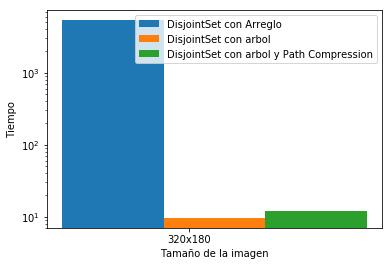

In [7]:
plt.clf()

metodos = csv["Metodo"].unique()
tiempos = {}
for file in images.keys():
    data_x_file = csv[csv["Filename"] == file]

    mediciones = {}
    for metodo in metodos:
        mediciones[metodo] = np.median(data_x_file[data_x_file["Metodo"] == metodo]["Tiempo"])
    tiempos[file] = mediciones
    
    
tiempos_x_metodos = {}    

for metodo in metodos:
    tiempos_x_metodos[metodo] = []
    for f in tiempos.keys():
        tiempos_x_metodos[metodo].append(tiempos[f][metodo])

i = 0
for k, v in tiempos_x_metodos.items():
    print(k, v)
    plt.bar([100*j+32*i for j in range(1, len(images.keys())+1)], v, width=32, label=k)
    i += 1

plt.legend();
plt.xlabel("Tamaño de la imagen")
plt.ylabel("Tiempo");
plt.xticks([100*j+24 for j in range(1, len(images.keys())+1)], ["320x180"][:len(images.keys())])
plt.yscale('log')

Incluso en el caso de la imagen más chica(320x180) el metodo con DisjointSet con Arreglo tarda varios ordenes de magnitud más que los otros dos casos, por lo que de ahora en adelante vamos a descartarlo por ser demasiado lento.

### Sin considerar DisjointSet con Arreglo

In [25]:
image_path = "../datos_entrada/ej1/"
csvFileName="./ej1_tiempos.csv"
testCases="testCases.in"
test_times = 10
images = {
        "sintetico_1_320x180.png": None,
        "sintetico_1_640x360.png": None,
        "sintetico_1_1280x720.png": None,
        "sintetico_1_1920x1080.png": None,
}
methods = [1, 2]

k = 500
for path in images:
    images[path] = preparar_img(path)

In [99]:
for m in methods:
    for imgName,imgData in images.items():
        completado = subprocess.run(["../../Resolucion/bin/ej1", str(m), str(k), imgName], stdout=subprocess.PIPE, input=imgData[2], universal_newlines=True)
        if completado.returncode != 0:
            print(f"ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={k} metodo={metodo}")

In [100]:
csv = pandas.read_csv(csvFileName)

DisjointSet con arbol [9.92124, 37.332499999999996, 145.326, 297.644]
DisjointSet con arbol y Path Compression [12.2046, 51.11945, 224.74450000000002, 468.841]


([<matplotlib.axis.XTick at 0x7f24a89e7940>,
 <a list of 4 Text xticklabel objects>)

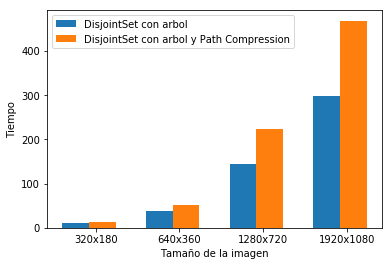

In [104]:
plt.clf()

metodos = [i for i in csv["Metodo"].unique() if i != "DisjointSet con Arreglo"]
tiempos = {}
for file in images.keys():
    data_x_file = csv[csv["Filename"] == file]

    mediciones = {}
    for metodo in metodos:
        mediciones[metodo] = np.median(data_x_file[data_x_file["Metodo"] == metodo]["Tiempo"])
    tiempos[file] = mediciones
    
    
tiempos_x_metodos = {}    

for metodo in metodos:
    tiempos_x_metodos[metodo] = []
    for f in tiempos.keys():
        tiempos_x_metodos[metodo].append(tiempos[f][metodo])

i = 0
for k, v in tiempos_x_metodos.items():
    print(k, v)
    plt.bar([100*j+32*i for j in range(1, len(images.keys())+1)], v, width=32, label=k)
    i += 1

plt.legend();
plt.xlabel("Tamaño de la imagen")
plt.ylabel("Tiempo");
plt.xticks([100*j+24 for j in range(1, len(images.keys())+1)], ["320x180", "640x360", "1280x720", "1920x1080"][:len(images.keys())])